In [22]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
from math import ceil
from astropy import stats 
from glob import glob
import matplotlib as mpl
from tqdm import tqdm

import sys
sys.path.append('/Users/abarnes/GitHub/misc/')
from data_cube_analysis import getdata

plt.style.use('paper.mplstyle')

In [2]:
inputfile = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/hnco43.TP_7M_12M_weighted_mosaic.rebin.K.kms.0.5kmschannel.galactic.fits'
print(inputfile)
hdu = fits.open(inputfile)[0]
print(hdu)

/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/hnco43.TP_7M_12M_weighted_mosaic.rebin.K.kms.0.5kmschannel.galactic.fits


In [3]:
def get_channel_maps(inputfile, start=-200, stop=200, step=20):
    """
    This function calculates the zeroth moment (total intensity) for each velocity channel in a data cube,
    and writes the results to a FITS file.

    Args:
    inputfile (str): Path to the input FITS file.
    cube (SpectralCube): The data cube from which the channel maps are to be extracted.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """

    # Use the get_cube function from the getdata module to extract the data cube from the FITS file.
    cube = getdata.get_cube(inputfile)
    
    # Define the velocity channels.
    channels = np.arange(start, stop, step) *u.km/u.s

    # Get the number of channels.
    n = len(channels)-1

    # Initialize an array to hold the channel map data.
    channelmaps_data = ['']*(n)

    # For each channel...
    for i in tqdm(range(n)): 

        # ...extract the cube for that channel...
        cube_channels = cube.spectral_slab(channels[i], channels[i+1])

        # ...and calculate the zeroth moment, storing the result in the array.
        channelmaps_data[i] = cube_channels.moment0().hdu.data
        channelmaps_data[i][channelmaps_data[i] == 0] = np.nan

    # Get the FITS header from the last cube's zeroth moment.
    channelmaps_header = cube_channels.moment0().hdu.header

    # Create a FITS HDU using the channel map data and the header.
    channelmaps_hdu = fits.PrimaryHDU(channelmaps_data, channelmaps_header)

    # Define the output file name by removing '.fits' from the input file name.
    outputfile = inputfile.replace('.fits', '')
 
    # Write the HDU to a FITS file.
    channelmaps_hdu.writeto('%s_chans.fits' %outputfile, overwrite=True)

    return(channelmaps_hdu)

In [99]:
def plot_channel_maps(channelmaps_hdu, outputfile=None, start=-200, stop=200, step=20, contour_levels=None, vmin=None, vmax=None):
    """
    This function plots all the channel maps contained in a FITS HDU in a grid with a specified number of columns.
    It shows the velocity range in the upper right corner of each plot.

    Args:
    channelmaps_hdu (HDU): The FITS HDU containing the channel maps.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """
    # Determine the number of channels from the FITS HDU.
    channels = channelmaps_hdu.header['NAXIS3']

    # Determine the number of rows needed for the plot grid.
    rows = ceil(channels / 5)  # 4 is the number of columns.

    # Initialize the plot figure.
    fig = plt.figure(figsize=(16,16*(rows/5)))
    
    # aligning with mopra images
    l = 0.8065474
    b = -0.1999737
    width = 0.2*0.9
    height = 0.2*0.9
    
    # for contours
    col_density = '../data/multiwavelength/regrid_crop/gaussfit_iter_beta175_column_gc_itervar_conv25.fits'
    
    # For each channel...
    for chan in tqdm(range(channels)):

        # if chan != 0: 
        #     continue
        
        # ...create a copy of the FITS HDU...
        channelmaps_hdu_ = channelmaps_hdu.copy()
        
        # ...replace the data in the HDU with the data for the current channel...
        channelmaps_hdu_.data = channelmaps_hdu_.data[chan]
        
        # ...create a subplot in the appropriate position in the grid...
        gc = aplpy.FITSFigure(channelmaps_hdu_, subplot=(rows, 5, chan+1), figure=fig)  # 4 columns
        gc.recenter(l, b, width=width, height=height)
        
        # ...display the channel map in grayscale and with contours...
        # gc.show_grayscale()
        gc.show_colorscale(cmap='inferno', vmin=vmin, vmax=vmax)
        # gc.show_contour(channelmaps_hdu_, levels=5)
        
        # Remove ticks etc
        gc.axis_labels.hide()
        gc.tick_labels.hide()
        gc.ticks.set_color('black')
        gc.ticks.set_linewidth(2)
        gc.set_nan_color('lightgrey')

        if chan == 0: 
            line = outputfile.split('_')[0].split('/')[-1].upper()
            if line == 'sio':
                gc.add_label(0.05, 0.05, 'SiO', relative=True, color='black', 
                            bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=20, ha='left', va='bottom')
            if line == 'hc3n':
                gc.add_label(0.05, 0.05, 'HC$_3$N', relative=True, color='black', 
                            bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=20, ha='left', va='bottom')            
            else: 
                gc.add_label(0.05, 0.05, outputfile.split('_')[0].split('/')[-1].upper(), relative=True, color='black', 
                            bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=20, ha='left', va='bottom')

        # ...and display the velocity range in the upper right corner.
        velo_range = f"{start + chan*step} to {start + (chan+1)*step} km/s"
        gc.add_label(0.03, 0.97, velo_range, relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=0.75), ha='left', va='top', size=13)
        
        # adding hershel column density contours
        if contour_levels!=None:
            gc.show_contour(col_density, levels=contour_levels, linewidths=0.9, colors='white')
            
        gc.show_ellipses(0.8119, -0.1868, 240/3600, 240/3600, edgecolor='white', linestyles='dotted', linewidths=2)

        ax_plot = fig.get_axes()[-1]
        ax_plot.grid(True, alpha=0.3, ls=':', color='white')
            
    # Adjust the subplot layout to reduce space between subplots
    fig.tight_layout(h_pad=0, w_pad=-0.6)
    plt.subplots_adjust(wspace=-0.06, hspace=0)

    # Adding the colorbar
    axes_list = fig.get_axes()
    cbaxes_ = axes_list[0].scatter([0,0],[0,0],cmap='inferno',c=[vmin, vmax],s=0)
    cbaxes = fig.add_axes([0.99, 0.05, 0.012, 0.9])  
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(cbaxes_, cax=cbaxes, norm=norm, extend='both')
    cb.ax.tick_params(labelsize=14) 
    cb.set_label(label='Integrated Intensity [K km/s]',weight='bold',fontsize=13)

    ax_cbar = fig.get_axes()[-1]
    ax_cbar.yaxis.set_ticks_position('both')
    ax_cbar.set_rasterized(True)
    
    # Save the figure. 
    if outputfile != None: 
        fig.savefig(outputfile, bbox_inches='tight')
        fig.savefig(outputfile.replace('pdf', 'png'), bbox_inches='tight')
    
    return()

In [100]:
channelmaps_hdu = get_channel_maps(inputfile, 
                                   start=-30, 
                                   stop=130, 
                                   step=10)

# ensuring plotting over same scale
data = channelmaps_hdu.data.copy()
vmin, vmax = np.nanpercentile(data, [0.1,99.9])
print(vmin, vmax)

outputfile = '../figures/hnco43_chans.pdf'

100%|██████████| 15/15 [00:44<00:00,  2.95s/it]


()

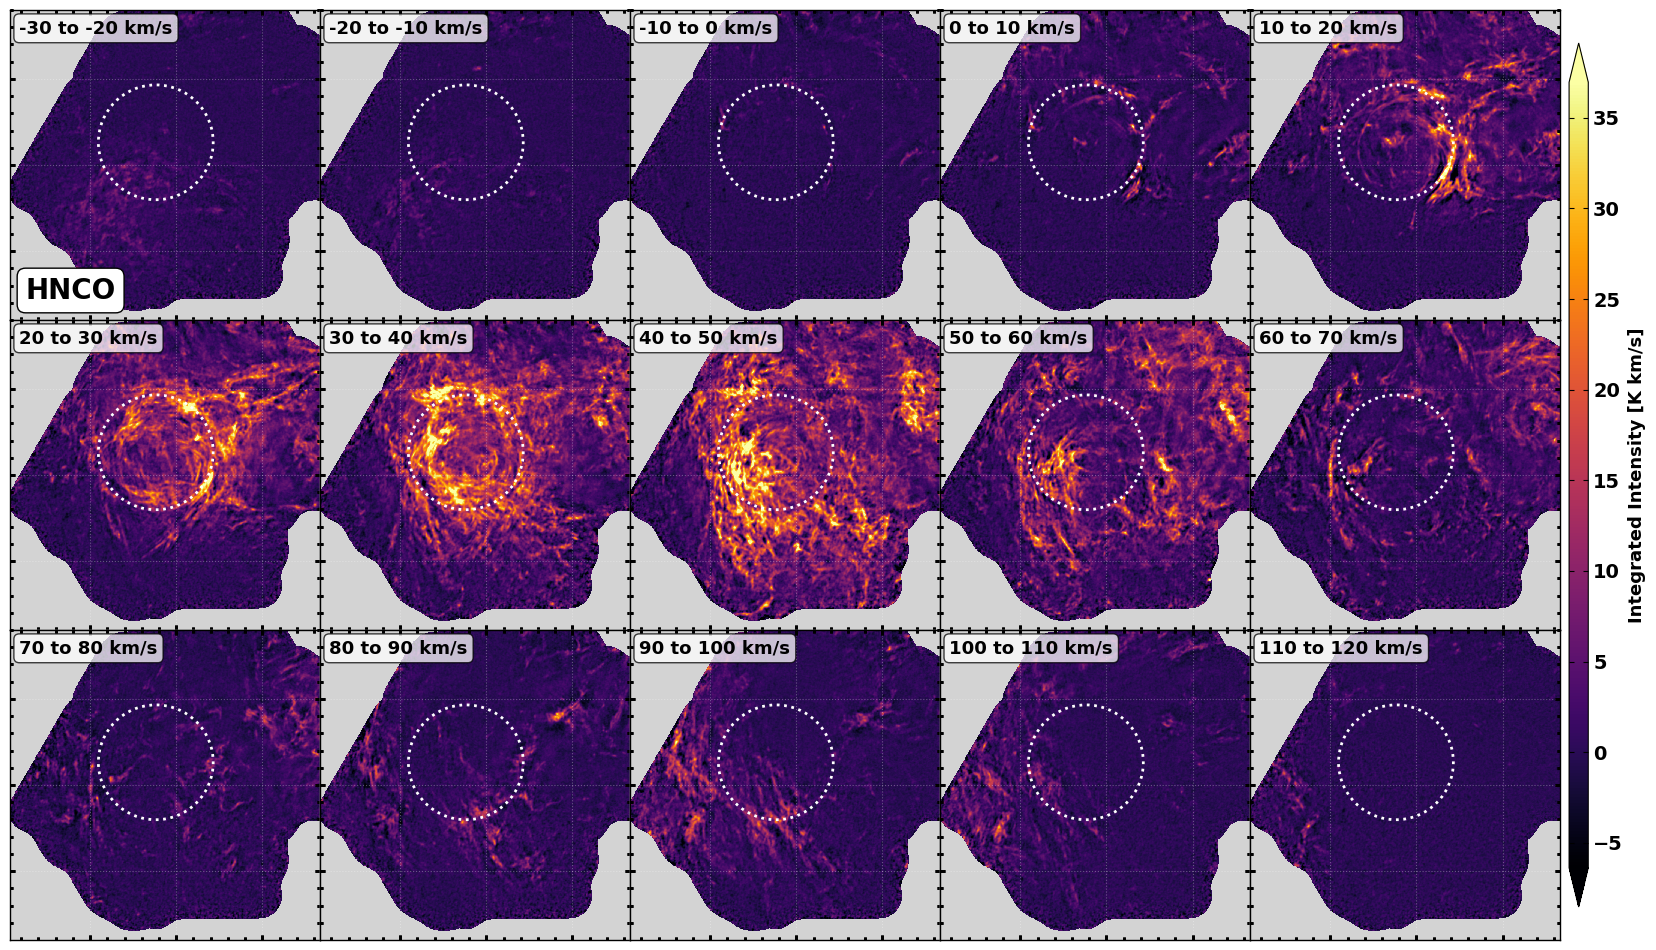

In [101]:
plot_channel_maps(channelmaps_hdu, 
                  start = -30, 
                  stop = 130, 
                  step = 10, 
                  vmin = vmin, 
                  vmax = vmax, 
                  outputfile = outputfile)

In [ ]:
# channelmaps_hdu = get_channel_maps(inputfile, 
#                                    start=-30, 
#                                    stop=130, 
#                                    step=2.5)

# # ensuring plotting over same scale
# data = channelmaps_hdu.data.copy()
# vmin, vmax = np.nanpercentile(data, [0.1,99.9])
# print(vmin, vmax)

# outputfile = '../figures/hnco_chans_highres.pdf'

# plot_channel_maps(channelmaps_hdu, 
#                   start = -30, 
#                   stop = 130, 
#                   step = 2.5, 
#                   vmin = vmin, 
#                   vmax = vmax, 
#                   outputfile = outputfile)

In [ ]:
def plot_channel_maps_indv(channelmaps_hdu, fileappend='', outputdir='../figures/', start=-200, stop=200, step=20, vmin=None, vmax=None, std=None):
    """
    This function plots all the channel maps contained in a FITS HDU in a grid with a specified number of columns.
    It shows the velocity range in the upper right corner of each plot.

    Args:
    channelmaps_hdu (HDU): The FITS HDU containing the channel maps.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """
    # Determine the number of channels from the FITS HDU.
    channels = channelmaps_hdu.header['NAXIS3']
    
    # aligning with mopra images
    l = 0.8065474
    b = -0.1999737
    width = 0.2*0.9
    height = 0.2*0.9
    
    # For each channel...
    for chan in range(channels):
        
        # if chan!=0:
        #     continue

        # ...create a copy of the FITS HDU...
        channelmaps_hdu_ = channelmaps_hdu.copy()
        
        # ...replace the data in the HDU with the data for the current channel...
        channelmaps_hdu_.data = channelmaps_hdu_.data[chan]
        
        # Initialize the plot figure.
        # ...create a subplot in the appropriate position in the grid...
        fig = plt.figure(figsize=(5,5))
        gc = aplpy.FITSFigure(channelmaps_hdu_, subplot=(1, 1, 1), figure=fig)  # 4 columns
        gc.recenter(l, b, width=width, height=height)
        
        # ...display the channel map in grayscale and with contours...
        # gc.show_grayscale()
        gc.show_colorscale(cmap='inferno', vmin=vmin, vmax=vmax)
        # gc.show_contour(channelmaps_hdu_, levels=5)
        
        gc.show_contour(channelmaps_hdu_, levels=[3*std], linewidths=0.9, colors='white', smooth=3)

        # Remove ticks etc
        gc.axis_labels.hide()
        gc.tick_labels.hide()
        gc.ticks.set_color('black')
        gc.ticks.set_linewidth(2)
        gc.set_nan_color('lightgrey')

        # ...and display the velocity range in the upper right corner.
        velo_range = f"{start + chan*step} to {start + (chan+1)*step} km/s"
        gc.add_label(0.05, 0.95, velo_range, relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=0.75), ha='left')
            
        gc.show_ellipses(0.8119, -0.1868, 240/3600, 240/3600, edgecolor='white', linestyles='dotted', linewidths=2)
    
        # Adjust the subplot layout to reduce space between subplots
        fig.tight_layout(h_pad=0, w_pad=-0.6)
        plt.subplots_adjust(wspace=-0.06, hspace=0)
        
        # Save the figure. 
        fig.savefig(outputdir+fileappend+'_%i.png' %chan, bbox_inches='tight')
    
        plt.close('all')

    return()

In [ ]:
channelmaps_hdu = get_channel_maps(inputfile, 
                                   start=-40, 
                                   stop=130, 
                                   step=0.5)

In [ ]:
# ensuring plotting over same scale
data = channelmaps_hdu.data.copy()
vmin, vmax = np.nanpercentile(data, [0.1, 99.9])
std = stats.mad_std(data, ignore_nan=True)
std = stats.mad_std(data[data<3*std], ignore_nan=True)
print(vmin, vmax, std)

plot_channel_maps_indv(channelmaps_hdu, 
                  start = -40, 
                  stop = 130, 
                  step = 0.5, 
                  vmin = vmin, 
                  vmax = vmax, 
                  std = std,
                  fileappend = 'hcno_chans/hcno_chans')

In [ ]:
import imageio
filenames = glob('../figures/hcno_chans/*.png')
filenames_sorted = sorted(filenames, key=lambda x: int(x.split('_')[-1].split('.')[0]))
images = []
for filename in filenames_sorted:
    images.append(imageio.imread(filename))
imageio.mimsave('../figures/hcno_chans/hnco_chans_movie.gif', images)